## RLlib continued

In [1]:
# HIDDEN
import gym
import numpy as np
import matplotlib.pyplot as plt

#### Saving the model

- We may want to save our trained model for future use.
- This is also called _checkpointing_, especially when done during a training loop.
- In RLlib, this can be done simply with:

```python
trainer.save()
```

It can then be later restored with

```python
trainer.restore()
```

Just make sure you create the trainer with the same environment and parameters when restoring from a checkpoint.

#### Evaluation

In RLlib, we can evaluate with `.evaluate()`:

In [20]:
eval_results = trainer.evaluate()

The evaluation output contains a lot of info. Let's look at a couple pieces:

In [21]:
eval_results["evaluation"]["episode_reward_mean"]

0.9810725552050473

That is, we reached the goal in 98% of the evaluation episodes. 

#### Evaluation

Histogram of episode rewards:

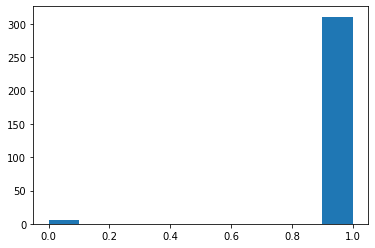

In [22]:
plt.hist(eval_results["evaluation"]["hist_stats"]["episode_reward"]);

#### Evaluation

Histogram of episode _lengths_:

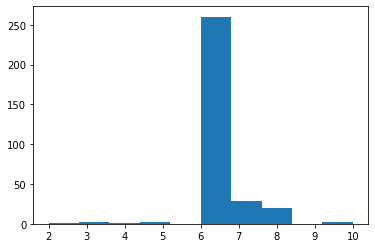

In [23]:
plt.hist(eval_results["evaluation"]["hist_stats"]["episode_lengths"]);

- The short ones are the failures, since it's impossible to reach the goal in 4 steps.
- Most of the time we reach the goal in the minimum number of steps (6).

#### Configuring the trainer

```python
trainer = rllib.agents.ppo.PPOTrainer(env="FrozenLake-v1", 
                                      config=trainer_config)
```

Remember this line? Earlier, we hid the `trainer_config`. Here's the config we hid:

```python
trainer_config = {
    "framework"             : "torch",
    "create_env_on_driver"  : True,
    "seed"                  : 0,
    "model"                 : {"fcnet_hiddens" : [32, 32]},
    "env_config"            : {"is_slippery" : False}}
```

#### Configuring the trainer

```python
trainer_config = {
    "framework"             : "torch",
    "create_env_on_driver"  : True,
    "seed"                  : 0,
    "model"                 : {"fcnet_hiddens" : [32, 32]},
    "env_config"            : {"is_slippery" : False}}
```

- `config={"framework" : "torch"}`: RLlib works with tensorflow (`"tf"` or `"tf2"`) and pytorch (`"torch"`)
- `"create_env_on_driver" : True`: This relates to Ray, and we will touch on it briefly, but not much in this course
-  `"seed" : 0`: This is used for reproducibility of the teaching materials, and is not normally needed
- `"model" : {"fcnet_hiddens" : [32, 32]}`: this tells RLlib to use a smaller-than-default neural network architecture, which helps this slide deck compile/run faster
- `"env_config" : {"is_slippery" : False}`: this selects the non-slippery Frozen Lake
  - All environment hyperparameters go in this sub-dictionary

#### sklearn / RLlib analogies

- We've seen some analogies (and departures) between SL and RL, both in concept and syntax. 
- Let's compare:

| SL/sklearn | RL/RLlib | Description  |
|-------------|---------|--------------|
| `ModelName(**hypers)` | `AlgoName(hypers, env)` | Initialize a model/algorithm |
| `.fit(X,y)`  | `.train()` | Training (fully for sklearn, one iteration for RLlib) |
| `.predict(x)` | `.compute_single_action(obs)` | Use the trained model once |
| `.score(X,y)` | `.evaluate()` | Evaluate the model |

# TODO

querying the policy

The code below loads the agent, seen in the slides, on the Random Lake environment. When you run the code, it prints out a 16x4 array. Each row corresponds to one of the 16 possible observations, and shows the probabilities of the agent taking each of the 4 possible actions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
from ray.rllib.agents.ppo import PPOTrainer
from envs import RandomLake
from utils import action_dist

trainer = PPOTrainer({"framework" : "torch", "create_env_on_driver" : True, "seed" : 0}, 
                     env=RandomLake)

trainer.restore("models/RandomLake/checkpoint-8")

lake = RandomLake()

plt.figure(figsize=(4,8))
plt.imshow(np.array([action_dist(trainer, lake, i) for i in range(16)]));
plt.xticks(np.arange(4), labels=["left", "down", "up", "right"]);
plt.yticks(np.arange(16), labels=np.arange(16));
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor");

ModuleNotFoundError: No module named 'envs'

this was originally from lesson 3.2. the idea is to look at the action distribtuion for each possible observation of frozen lake. here, in the random lake actually, you can see that it's most sure about what to do right before the goal, and gets less sure.

what might also be cool is to just make a 4x4 map and the colour can be the max probability (or -entropy or whatever, a measure or sureness), so we can see that it gets more sure closer to the goal

#### Let's apply what we learned!

## RLlib trainer methods
<!-- multiple choice -->

#### Training

_Which of the following most accurately describes the role of `trainer.train()` in RLlib?_

- [ ] It neither collects a data set of episodes nor learns a policy. | Are you sure?
- [ ] It learns a policy from a fixed data set of episodes. | Remember, calling train() causes the agent to play through episodes.
- [ ] It creates a data set of episodes but does not learn a policy. | Remember, calling train() learns a policy.
- [x] It simultaneously collects a data set of episodes and also learns a policy. | You got it!

#### Passing in the dataset

_When using scikit-learn for supervised learning we call `fit(X,y)`, but with RLlib we call `train()` without passing in the dataset. Why?_

- [x] Because RLlib was given access to the environment when the trainer was initialized, and this is all it needs.
- [ ] Because reinforcement learning does not involve data.
- [ ] Because X and y are passed into a different RLlib method.

#### Scoring

_Which of the following RLlib trainer methods is most analogous to scikit-learn's `.predict()` function?_

- [ ] train() | This is more like _fit()_ in scikit-learn.
- [x] compute_single_action()
- [ ] evaluate() | This is more like _score()_ in scikit-learn. 

## Slippery Frozen Lake
<!-- coding exercise -->

In the slides, we trained an agent to reliably reach the goal in the **non-slippery** Frozen Lake environment. Here, try the same thing with the **slippery** Frozen Lake. Train your agent until it reaches the goal at least 20% of the time. Then, answer the multiple choice question below.

Note the addition of `"evaluation_config"` in the trainer config. This ensures that the agent acts deterministically during evaluation.

In [24]:
# EXERCISE
from ray import rllib

slippery_trainer_config = {
    "framework"             : "torch",
    "create_env_on_driver"  : True,
    "seed"                  : 0,
    "model"                 : {"fcnet_hiddens" : [32, 32]},
    "env_config"            : {"is_slippery" : True},
    "evaluation_config"     : {"explore" : False}}

slippery_trainer = rllib.agents.ppo.PPOTrainer(____)

for i in range(____):
    train_info = slippery_trainer.____()
    
eval_results = ____.evaluate()

print(eval_results["evaluation"]["episode_reward_mean"])

NameError: name '____' is not defined

In [25]:
# SOLUTION
from ray import rllib

slippery_trainer_config = {
    "framework"             : "torch",
    "create_env_on_driver"  : True,
    "seed"                  : 0,
    "model"                 : {"fcnet_hiddens" : [32, 32]},
    "env_config"            : {"is_slippery" : True},
    "evaluation_config"     : {"explore" : False}}

slippery_trainer = rllib.agents.ppo.PPOTrainer(env="FrozenLake-v1", config=slippery_trainer_config)

for i in range(12): # There is randomness here, but 12 should be enough most of the time
    train_info = slippery_trainer.train()
    
eval_results = slippery_trainer.evaluate()

print("Frequency of reaching goal: %.1f%%" % (eval_results["evaluation"]["episode_reward_mean"]*100))

print("Action performed from top-right:", slippery_trainer.compute_single_action(3, explore=False))

Frequency of reaching goal: 3.6%
Action performed from top-right: 1


#### Action performed from top-right

According to the trained policy, what action is performed when the agent is at the top-right of the arena? This is printed out by the code.

- [ ] left (0) | When we ran the code, we got something different here.
- [ ] down (1) | When we ran the code, we got something different here.
- [ ] right (2) | When we ran the code, we got something different here.
- [x] up (3) | You got it!

#### Interpreting the policy

Recall that the arena looks like this:

```
SFFF
FHFH
FFFH
HFFG
```

In this slippery environment, you do your intended action 1/3 of the time, and each of the two perpendicular directions 1/3 of the time. You never go the opposite of the intended direction.

In the previous question, we saw that, from the **top-right corner** (observation 3), the agent tries to move up (action 3). Why do you think the agent tries to move up?

- [ ] 'Up' is an arbitrary choice because we did not train the agent.
- [ ] The agent receives a reward for the 'up' action. 
- [x] The agent wants to avoid falling into the hole below it, so the 'up' action is the safest choice.
- [ ] Moving up brings the agent closer to the goal.

## Rendering the trained agent
<!-- coding exercise -->

Fill in the blanks in the code below so that the code performs the observation-action-reward loop for one episode. Then, run the code and watch the trained agent navigate the slippery Frozen Lake. Then, answer the multiple choice question below.

In [29]:
# EXERCISE
from ray import rllib
import gym

from ipywidgets import Output
from IPython import display
import time

slippery_trainer_config = {
    "framework"             : "torch",
    "create_env_on_driver"  : True,
    "seed"                  : 0,
    "model"                 : {"fcnet_hiddens" : [32, 32]},
    "env_config"            : {"is_slippery" : True},
    "evaluation_config"     : {"explore" : False}}

slippery_trainer = rllib.agents.ppo.PPOTrainer(env="FrozenLake-v1", config=slippery_trainer_config)

slippery_trainer.restore("models/FrozenLakeSlippery/checkpoint-20")
env = gym.make("FrozenLake-v1", is_slippery=True)

out = Output();
display.display(out);

with out:
    obs = env.reset()
    env.seed(1)
    done = False
    while not done:
        action = slippery_trainer.____(____, explore=False)
        obs, rewards, done, _ = env.step(____)
        
        out.clear_output(wait=True)
        env.render()
        time.sleep(0.5)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
# SOLUTION
from ray import rllib
import gym

from ipywidgets import Output
from IPython import display
import time

slippery_trainer_config = {
    "framework"             : "torch",
    "create_env_on_driver"  : True,
    "seed"                  : 0,
    "model"                 : {"fcnet_hiddens" : [32, 32]},
    "env_config"            : {"is_slippery" : True},
    "evaluation_config"     : {"explore" : False}}

slippery_trainer = rllib.agents.ppo.PPOTrainer(env="FrozenLake-v1", config=slippery_trainer_config)

slippery_trainer.restore("models/FrozenLakeSlippery/checkpoint-20")
env = gym.make("FrozenLake-v1", is_slippery=True)

out = Output();
display.display(out);

with out:
    obs = env.reset()
    env.seed(1)
    done = False
    while not done:
        action = slippery_trainer.compute_single_action(obs, explore=False)
        obs, rewards, done, _ = env.step(action)
        
        out.clear_output(wait=True)
        env.render()
        time.sleep(0.5)

#### Choose the option below that best describes the agent's treacherous journey to the goal.

- [ ] The agent visits the top-right square in this episode.
- [ ] The agent never returns to the start state after leaving it initially.
- [ ] The agent does not reach the goal during the episode.
- [x] The agent sees observation 11 exactly once on its journey.

In [ ]:
# TODO: should this last exercise be moved from 1.4 to 1.3? it's more about policies than RLlib.